In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             roc_auc_score,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette("Greens_d")

print("Libraries loaded successfully")


Libraries loaded successfully


In [2]:
df = pd.read_csv('ccs_pumf_2024-002.csv')

df_clean = df.replace(-7, np.nan).replace(-8, np.nan)
df_users = df_clean[df_clean['canpurpose_dv'].isin([1, 2, 3])].copy()

purpose_labels = {1: 'Non-Medical', 2: 'Both', 3: 'Medical'}
df_users['purpose'] = df_users['canpurpose_dv'].map(purpose_labels)

print(f"Dataset loaded: {df_users.shape}")
print(f"\nPurpose distribution:")
print(df_users['purpose'].value_counts())


Dataset loaded: (3551, 597)

Purpose distribution:
Non-Medical    2381
Both            671
Medical         499
Name: purpose, dtype: int64


In [3]:
feature_cols = [
    # Demographics
    'age6', 'sex', 'education3',
    
    # Health status — asked of all users
    'health_physical', 'health_mental',
    
    # Route of administration — asked of all users
    'use_modes_smoke', 'use_modes_vape', 'use_modes_edible',
    'use_modes_bev', 'use_modes_oil', 'use_modes_dab', 'use_modes_topical',
    
    # Beliefs — asked of all users
    'belief_smoke', 'belief_vapour', 'belief_edible',
    'belief_thc', 'belief_habit',
]

# Target — binary: Medical/Both=1, Non-Medical=0
df_users['target'] = df_users['canpurpose_dv'].apply(
    lambda x: 1 if x in [2, 3] else 0
)

print("Target distribution:")
print(f"0 = Non-Medical: {(df_users['target']==0).sum()}")
print(f"1 = Medical (inc. Both): {(df_users['target']==1).sum()}")

X = df_users[feature_cols].copy()
y = df_users['target'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"\nMissing values:")
print(X.isnull().sum()[X.isnull().sum() > 0])


Target distribution:
0 = Non-Medical: 2381
1 = Medical (inc. Both): 1170

Feature matrix shape: (3551, 17)

Missing values:
education3           27
health_physical      12
health_mental        12
use_modes_smoke      63
use_modes_vape       63
use_modes_edible     63
use_modes_bev        63
use_modes_oil        63
use_modes_dab        63
use_modes_topical    63
belief_smoke         18
belief_vapour        21
belief_edible        10
belief_thc            7
belief_habit          9
dtype: int64


In [4]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Impute missing values with most frequent value
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=feature_cols
)

print("Missing values after imputation:")
print(X_imputed.isnull().sum().sum())

# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # ensures equal proportion of medical/non-medical in both sets
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

Missing values after imputation:
0

Training set: (2840, 17)
Test set: (711, 17)

Training target distribution:
0    1904
1     936
Name: target, dtype: int64

Test target distribution:
0    477
1    234
Name: target, dtype: int64


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Model 1 — Logistic Regression
print("=" * 50)
print("MODEL 1 — LOGISTIC REGRESSION")
print("=" * 50)

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr, 
      target_names=['Non-Medical', 'Medical']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]):.3f}")

# Model 2 — Random Forest
print("\n" + "=" * 50)
print("MODEL 2 — RANDOM FOREST")
print("=" * 50)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf,
      target_names=['Non-Medical', 'Medical']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]):.3f}")

MODEL 1 — LOGISTIC REGRESSION
              precision    recall  f1-score   support

 Non-Medical       0.76      0.90      0.82       477
     Medical       0.66      0.42      0.52       234

    accuracy                           0.74       711
   macro avg       0.71      0.66      0.67       711
weighted avg       0.73      0.74      0.72       711

ROC-AUC Score: 0.754

MODEL 2 — RANDOM FOREST
              precision    recall  f1-score   support

 Non-Medical       0.76      0.85      0.80       477
     Medical       0.60      0.45      0.51       234

    accuracy                           0.72       711
   macro avg       0.68      0.65      0.66       711
weighted avg       0.71      0.72      0.71       711

ROC-AUC Score: 0.719


In [6]:
print("=" * 50)
print("MODEL 1 — LOGISTIC REGRESSION (Balanced)")
print("=" * 50)

lr_balanced = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    class_weight='balanced'  # fixes imbalance
)
lr_balanced.fit(X_train, y_train)
y_pred_lr_bal = lr_balanced.predict(X_test)

print(classification_report(y_test, y_pred_lr_bal,
      target_names=['Non-Medical', 'Medical']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, lr_balanced.predict_proba(X_test)[:,1]):.3f}")

print("\n" + "=" * 50)
print("MODEL 2 — RANDOM FOREST (Balanced)")
print("=" * 50)

rf_balanced = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight='balanced'  # fixes imbalance
)
rf_balanced.fit(X_train, y_train)
y_pred_rf_bal = rf_balanced.predict(X_test)

print(classification_report(y_test, y_pred_rf_bal,
      target_names=['Non-Medical', 'Medical']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf_balanced.predict_proba(X_test)[:,1]):.3f}")

MODEL 1 — LOGISTIC REGRESSION (Balanced)
              precision    recall  f1-score   support

 Non-Medical       0.82      0.73      0.77       477
     Medical       0.55      0.66      0.60       234

    accuracy                           0.71       711
   macro avg       0.68      0.70      0.69       711
weighted avg       0.73      0.71      0.72       711

ROC-AUC Score: 0.755

MODEL 2 — RANDOM FOREST (Balanced)
              precision    recall  f1-score   support

 Non-Medical       0.75      0.86      0.80       477
     Medical       0.60      0.43      0.50       234

    accuracy                           0.72       711
   macro avg       0.68      0.64      0.65       711
weighted avg       0.70      0.72      0.70       711

ROC-AUC Score: 0.726


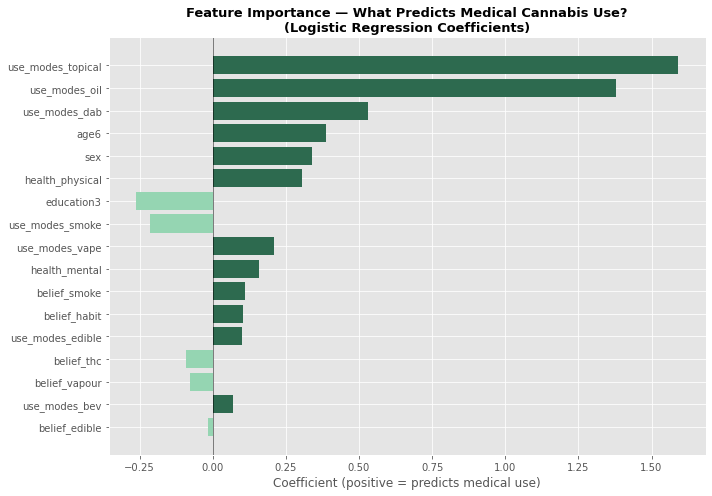

Figure 8 saved successfully


In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_balanced.coef_[0]
})

# Sort by absolute value
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=True)

# Color positive vs negative
colors = ['#2d6a4f' if c > 0 else '#95d5b2' 
          for c in coefficients['Coefficient']]

ax.barh(coefficients['Feature'], 
        coefficients['Coefficient'],
        color=colors)

ax.set_title('Feature Importance — What Predicts Medical Cannabis Use?\n(Logistic Regression Coefficients)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Coefficient (positive = predicts medical use)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('fig8_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 8 saved successfully")

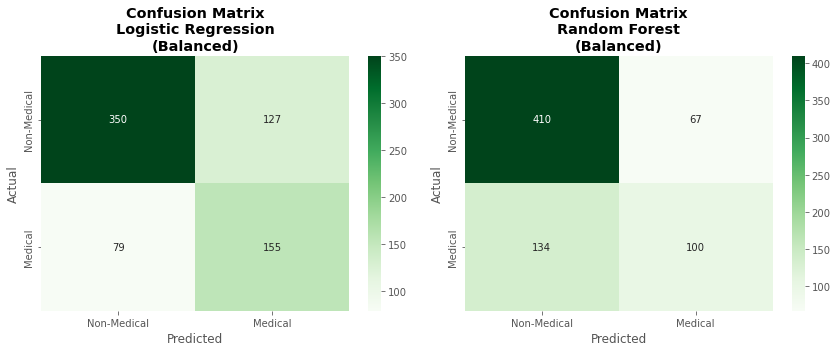

Figure 9 saved successfully


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (model, name, preds) in enumerate([
    (lr_balanced, 'Logistic Regression\n(Balanced)', y_pred_lr_bal),
    (rf_balanced, 'Random Forest\n(Balanced)', y_pred_rf_bal)
]):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, 
                annot=True, 
                fmt='d',
                cmap='Greens',
                xticklabels=['Non-Medical', 'Medical'],
                yticklabels=['Non-Medical', 'Medical'],
                ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix\n{name}', fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('fig9_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 9 saved successfully")

## Predictive Model Results

**Best Model:** Logistic Regression with class balancing
- Overall accuracy: 71%
- Medical user recall: 66%
- ROC-AUC: 0.755

**Key Predictors of Medical Cannabis Use:**

| Feature | Coefficient | Direction |
|---------|-------------|-----------|
| Topical use | 1.5920 | Predicts Medical |
| Oil/tincture use | 1.3774 | Predicts Medical |
| Concentrate use | 0.5301 | Predicts Medical |
| Age | 0.3864 | Predicts Medical |
| Sex (female) | 0.3379 | Predicts Medical |
| Physical health | 0.3058 | Predicts Medical |
| Education | -0.2622 | Predicts Non-Medical |
| Smoking | -0.2134 | Predicts Non-Medical |
| Vaping | 0.2092 | Predicts Medical |

**Key Findings:**
- Topical and oil use are by far the strongest predictors of 
  medical cannabis use, reflecting their clinical specificity
- Smoking predicts recreational use — consistent with its 
  social and cultural associations
- Higher education predicts recreational use
- Older age and worse physical health predict medical use
- HOW people consume cannabis is more predictive than 
  WHO they are demographically — suggesting route of 
  administration is a meaningful signal for medical intent
  in population-level surveillance data

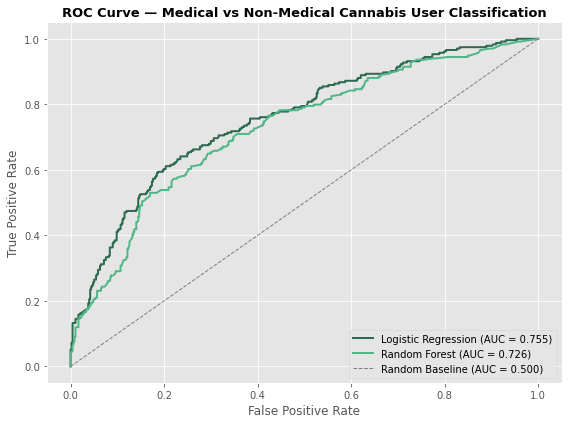

In [11]:
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(8, 6))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_balanced.predict_proba(X_test)[:,1])
ax.plot(fpr_lr, tpr_lr, color='#2d6a4f', linewidth=2,
        label=f'Logistic Regression (AUC = 0.755)')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_balanced.predict_proba(X_test)[:,1])
ax.plot(fpr_rf, tpr_rf, color='#52b788', linewidth=2,
        label=f'Random Forest (AUC = 0.726)')

# Random baseline
ax.plot([0, 1], [0, 1], color='gray', linewidth=1, 
        linestyle='--', label='Random Baseline (AUC = 0.500)')

ax.set_title('ROC Curve — Medical vs Non-Medical Cannabis User Classification',
             fontsize=13, fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('fig10_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

